# Scalability test for OpenMP 



In [10]:
import csv

# defi name of file log and output data csv file
log_file = 'omp_scaling.log'
csv_file = 'omp_scaling.csv'

# storing data
data = []
current_data = {}

# read log file and extract data
with open(log_file, 'r') as file:
    for line in file:
        if line.startswith('\tCommand being timed:'):
            if current_data:
                data.append(current_data)
                current_data = {}
            
            np = line.split('./mandelbrot_scal_omp')[1].split(' ')[0] # get number of threads

            current_data['np'] = np

        elif ':' in line:
            key, value = line.strip().split(':')
            key = key.strip()
            value = value.strip().split(' ')[0] # to remove units and extra info
            current_data[key] = value

    # add last block of data if any
    if current_data:
        data.append(current_data)

# write data to csv file
fieldnames = data[0].keys() # get the keys of the first element of the list

with open(csv_file, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for entry in data:
        writer.writerow(entry)

print('Data extracted and saved to', csv_file)



Data extracted and saved to omp_scaling.csv


Similar output for the analysis of the MPI scalability test, but now for the OpenMP scalability test. 

# Analysis of the Efficiency 

Here we will compare user time, system time, and total execution time for different OpenMP threads which are tested for the scalability of the code.

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# load data
data = pd.read_csv('omp_scaling.csv')

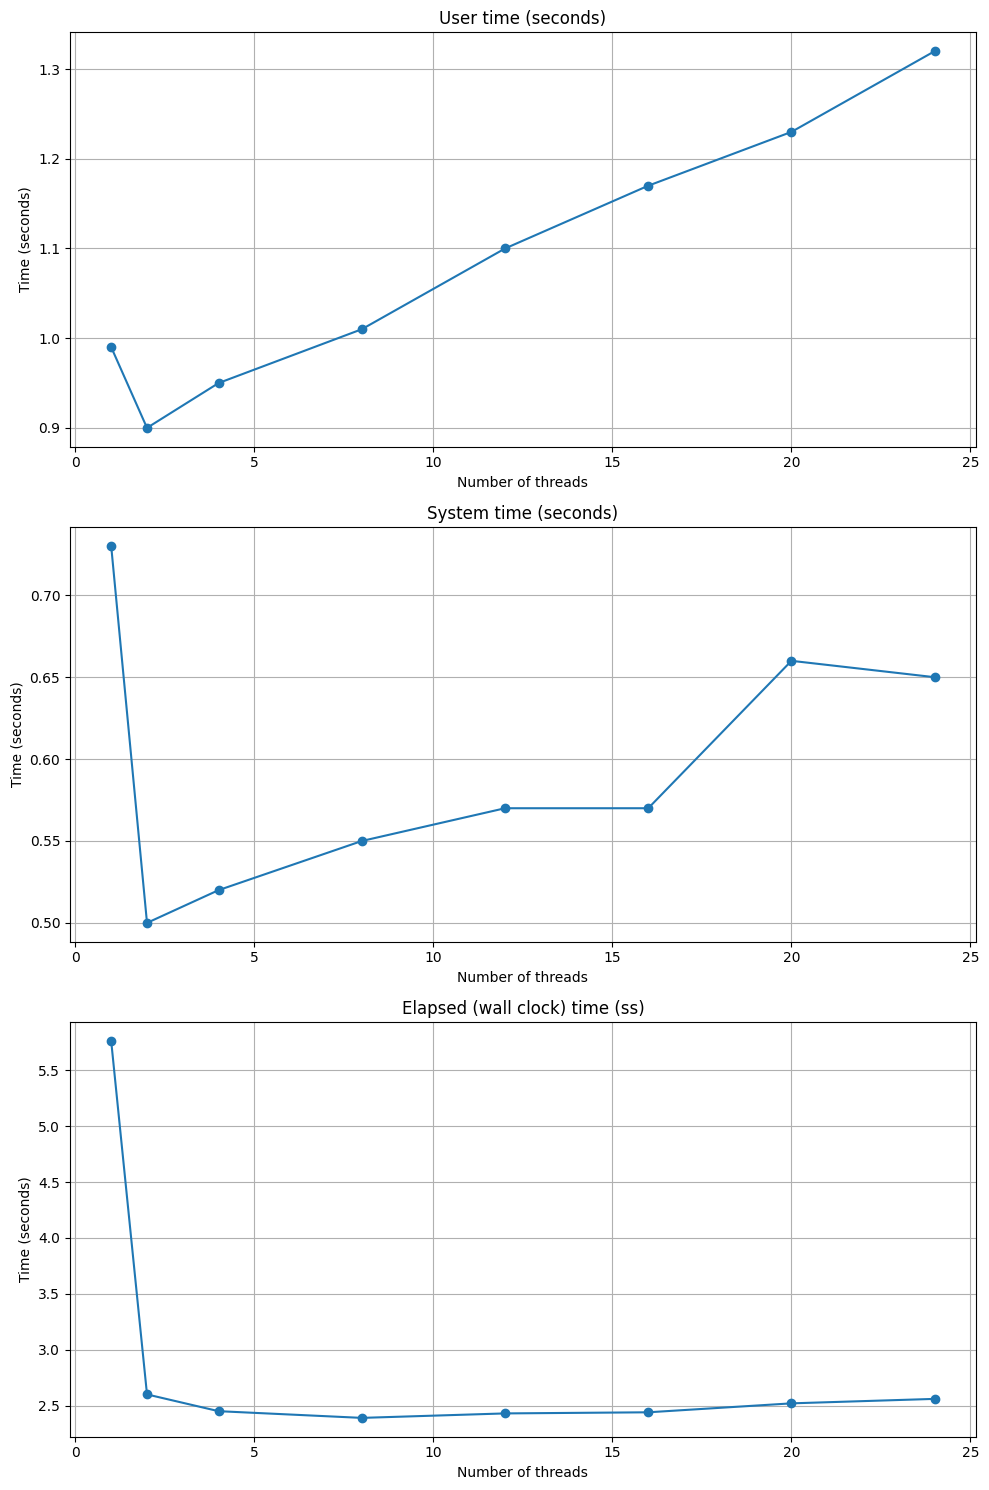

In [27]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Plot 'User time (seconds)'
ax[0].plot(data['np'], data['User time (seconds)'], marker='o')
ax[0].set_title('User time (seconds)')
ax[0].set_xlabel('Number of threads')
ax[0].set_ylabel('Time (seconds)')
ax[0].grid(True)

# Plot 'System time (seconds)'
ax[1].plot(data['np'], data['System time (seconds)'], marker='o')
ax[1].set_title('System time (seconds)')
ax[1].set_xlabel('Number of threads')
ax[1].set_ylabel('Time (seconds)')
ax[1].grid(True)

# Plot 'Elapsed (wall clock) time (ss)'
ax[2].plot(data['np'], data['Elapsed (wall clock) time (ss)'], marker='o')
ax[2].set_title('Elapsed (wall clock) time (ss)')
ax[2].set_xlabel('Number of threads')
ax[2].set_ylabel('Time (seconds)')
ax[2].grid(True)

plt.tight_layout()
plt.show()

### Data interpretation

1. **User time**: The graph of user time shows an almost linear increase as the number of threads increases. This indicates that the programme is performing more overall work with the addition of threads, which is to be expected if each thread performs a significant portion of the total work. However, a linear increase in user time with more threads could also suggest that there are portions of code that do not benefit from parallelism or that there are synchronisations or communication latencies that limit the effectiveness of parallelisation. Ideally, we would like to see a plateau or even a decrease in user time per thread as the number of threads increases, indicating an effective use of parallelism to reduce the load on each core.

2. **System time**: The system time initially shows a dramatic decrease, stabilising later and increasing slightly as more threads are added. The initial decrease is positive, indicating that the system overhead per thread decreases when there are few threads. The later increase may reflect the increasing overhead associated with handling more threads. An increase in system time with many threads may indicate that the management of the threads themselves, including synchronisation between them, is consuming system resources. It may be useful to explore methods of reducing this overhead, such as optimising critical sections of code or using a different parallelism model.

3. **Elapsed (Wall Clock) Time**: This graph shows a significant improvement in total execution time as the number of threads increases from 1 to about 10, after which the benefits stabilise. This is a clear indicator that the application benefits from parallelism up to a certain point, beyond which thread management overheads and resource saturation probably limit further improvements. The plateau in execution time suggests that there are physical limits or limitations in the code that prevent further improvements. Further optimisation of the code or an exploration of hardware limitations, such as memory bandwidth or cache conflicts, which may affect scalability, may be necessary.

In summary, the results show that the programme benefits from the addition of threads up to a certain number, after which the gains in execution time are reduced. This is typical of programmes performing heavy calculations that can be effectively parallelised, but only as long as no resource bottlenecks or architecture limitations are encountered.

# Bottlenecks

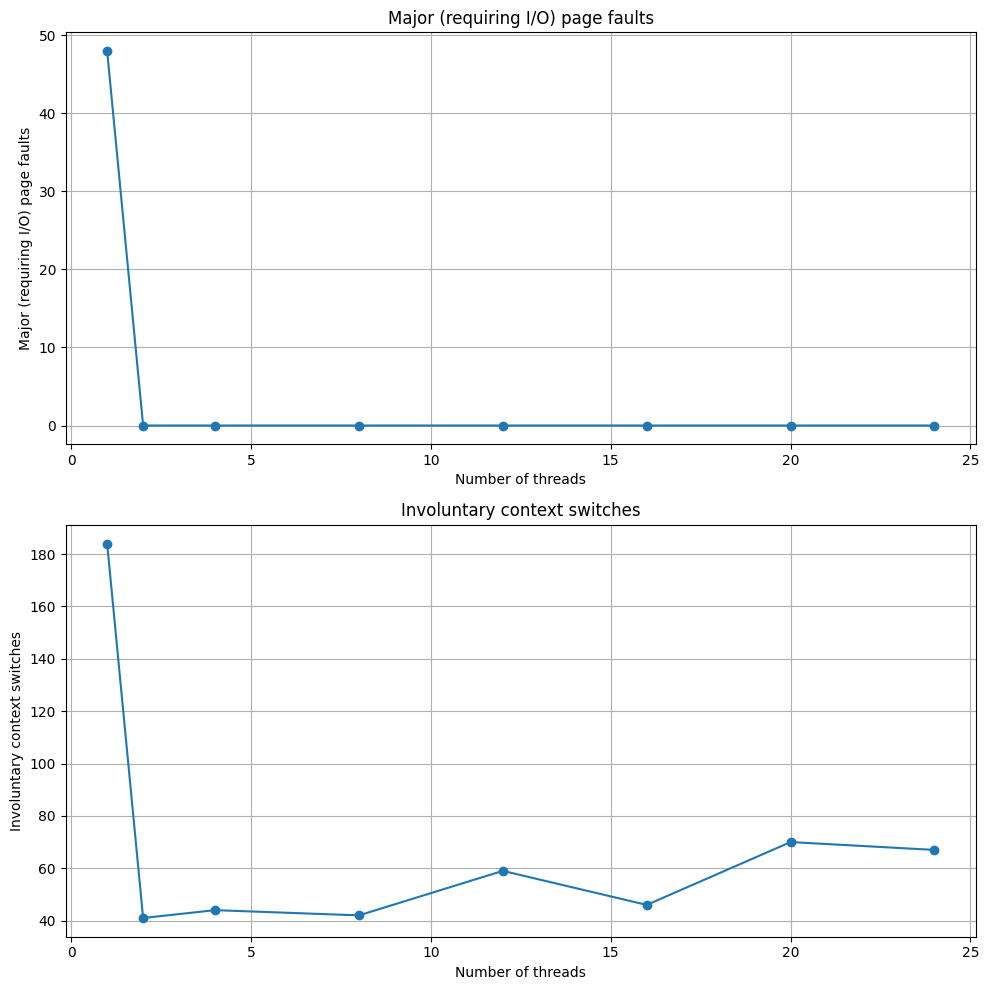

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Plot 'Major (requiring I/O) page faults'
ax[0].plot(data['np'], data['Major (requiring I/O) page faults'], marker='o')
ax[0].set_title('Major (requiring I/O) page faults')
ax[0].set_xlabel('Number of threads')
ax[0].set_ylabel('Major (requiring I/O) page faults')
ax[0].grid(True)

# Plot 'Involuntary context switches'
ax[1].plot(data['np'], data['Involuntary context switches'], marker='o')
ax[1].set_title('Involuntary context switches')
ax[1].set_xlabel('Number of threads')
ax[1].set_ylabel('Involuntary context switches')
ax[1].grid(True)

plt.tight_layout()
plt.show()

### Data interpretation

1. **Major (requiring I/O) page faults**: The graph of ‘major page faults’ shows a high number of faults when using a single thread, with a drastic decrease already with the introduction of a few additional threads, then stabilising at zero for subsequent thread increments. A high major page fault at the beginning may indicate that the process is accessing a large amount of data for the first time, which is not resident in memory and must be loaded from slower storage devices (such as disk). The rapid decrease with multiple threads suggests that once data is loaded into memory, access becomes more efficient and less likely to cause further page faults. This may be a sign that memory is efficiently shared and utilised between threads after the first load.

2. **Involuntary context switches**: Involuntary context switches show a high frequency at the beginning with only one thread, followed by a marked decrease and then a slight fluctuation but generally remaining at lower levels. A high number of initial involuntary context switches may be due to the fact that the operating system often has to intervene to manage the process, possibly due to resource waits. The decrease as threads increase indicates that the workload is more evenly distributed among threads, reducing the need for the operating system to intervene frequently. Fluctuations in later stages may reflect competition for system resources such as CPU or memory, particularly when the number of threads approaches the number of available physical cores.

The significant decrease in both page faults and involuntary context switches as threads increase is positive, indicating that the programme scales well in terms of resource management as parallelism increases. However, it is also essential to monitor these metrics to assess whether other types of overhead or limitations occur, such as memory bandwidth saturation or cache limitations, which may not be immediately apparent from execution times alone.

# Parallelization Impact

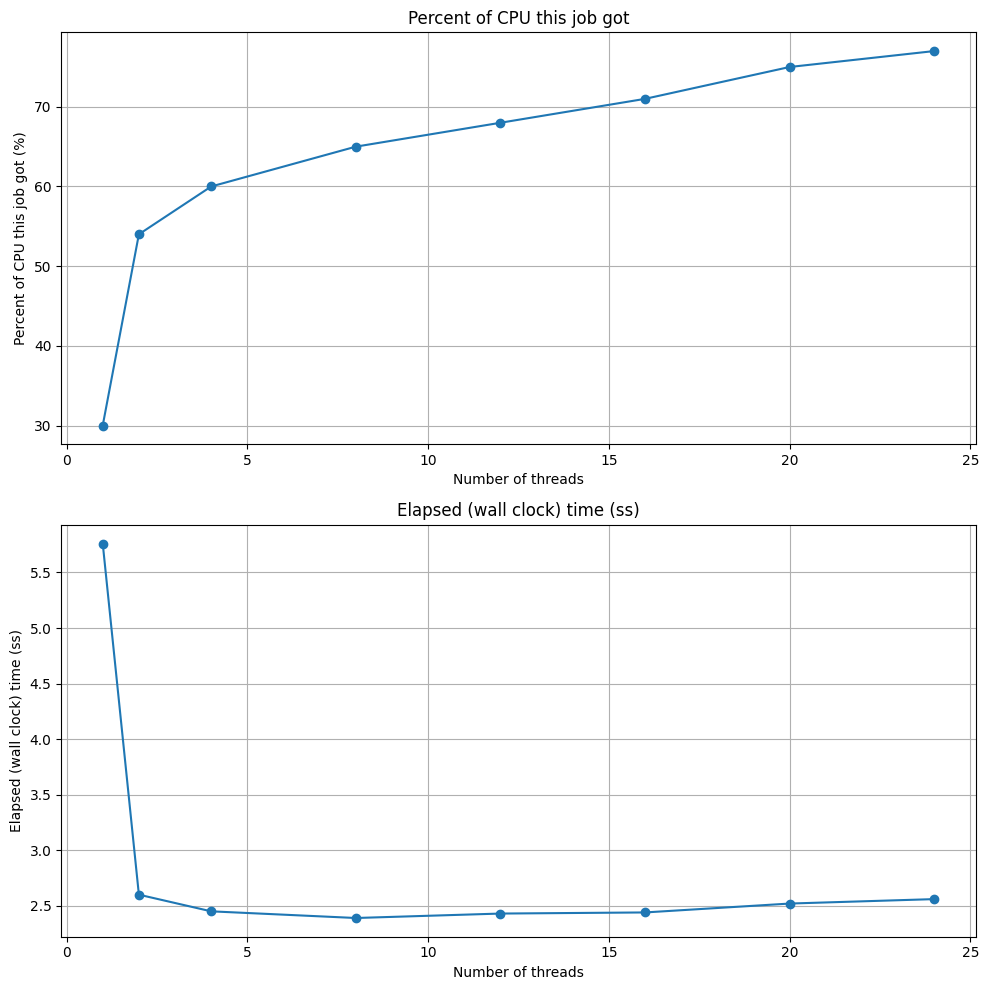

In [30]:
# Convert 'Percent of CPU this job got' to numeric
data['Percent of CPU this job got'] = data['Percent of CPU this job got'].str.rstrip('%').astype('float')

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Plot 'Percent of CPU this job got'
ax[0].plot(data['np'], data['Percent of CPU this job got'], marker='o')
ax[0].set_title('Percent of CPU this job got')
ax[0].set_xlabel('Number of threads')
ax[0].set_ylabel('Percent of CPU this job got (%)')
ax[0].grid(True)

# Plot 'Elapsed (wall clock) time (ss)'
ax[1].plot(data['np'], data['Elapsed (wall clock) time (ss)'], marker='o')
ax[1].set_title('Elapsed (wall clock) time (ss)')
ax[1].set_xlabel('Number of threads')
ax[1].set_ylabel('Elapsed (wall clock) time (ss)')
ax[1].grid(True)

plt.tight_layout()
plt.show()

### Data interpretation

1. **Percent of CPU this job got**: This graph shows a marked increase in the percentage of CPU used as the number of threads increases, starting from a relatively low level with only one thread and rising consistently to a plateau around 70 per cent. The increase in CPU percentage indicates that adding more threads allows the programme to utilise more processor resources simultaneously, suggesting good initial scalability of parallelism. The plateau may indicate that the programme is reaching the limits of scalability on this particular hardware architecture, possibly due to physical limitations such as the number of available cores, memory bandwidth saturation, or the workload is no longer able to be effectively divided between additional threads.

2. **Elapsed (wall clock) Time**: The graph of execution time shows a sharp drop in execution time when going from 1 to several threads, then stabilising at a low value after about 5 threads. This is a typical indicator of a good response to initial parallelisation. The rapid reduction in execution time as the first threads increase shows that the programme benefits significantly from the distribution of the workload among multiple threads. The stabilisation of time suggests that further thread additions do not lead to significant improvements, which may be due to reaching an I/O limit, memory saturation or the operating system's ability to handle threads. This stabilisation implies that we have found the optimal number of threads for the given problem in this specific architecture.

These results indicate that the programme has a good degree of parallelism up to a certain number of threads, beyond which no significant benefits are achieved. This type of information is crucial for deciding how to allocate resources in a production environment and for optimising further software development:

- Optimising the Number of Threads: Based on the results, it may be ideal to configure the programme to use a number of threads close to the plateau point to maximise efficiency.
- Exploration of Other Optimisations: Consider exploring optimisations beyond simply increasing the number of threads, such as improvements in the algorithm, memory management and synchronisation overhead reduction.



# Summary 

From analysing the scalability of OpenMP across the three main metrics - efficiency, bottlenecks, and impact of parallelisation - we can draw some key conclusions on how the programme performs as the number of threads increases. Here is a summary of the results and their implications:

1. **Efficiency**: 
    - User Time: Increases almost linearly, suggesting that each thread contributes to the overall workload, but the linear increase could also indicate a lack of optimisation in the workload distributed between threads.
    - System Time: Decreases initially and then stabilises, indicating that system overhead per thread decreases with more threads until it stabilises, suggesting efficient use of system resources after a certain point.
    - Wall Clock Time: Decreases drastically as threads increase to a certain number, then stabilises, showing clear benefits of parallelisation up to a saturation point.

2. **Bottlenecks**:
    - Major Page Faults: Very high with a single thread, decreasing rapidly with increasing threads, suggesting that the programme becomes more efficient in memory management with more threads.
    - Involuntary Context Switches: High with a single thread and decreasing significantly with increasing threads, indicating better resource management and less operating system intervention with more threads.

3. **Parallelisation Impact**:
    - CPU Percentage: Increases as more threads are added, indicating more efficient use of processor resources with more threads, but reaches a plateau that may reflect physical limits or saturation.
    - Elapsed Wall Clock Time: Shows a significant improvement in execution time with the initial addition of threads, stabilising at a low value suggesting efficient workload optimisation up to a certain number of threads.

The analysis shows that the programme benefits significantly from parallelisation with OpenMP up to a certain number of threads. Beyond that number, execution time gains decrease and stabilise, suggesting that further improvements may not be achievable just by adding threads. This suggests that there are physical limitations, such as the number of available cores or memory bandwidth, that limit further improvements. Effective memory management and reduced system overhead are evident in the tests, indicating that the programme is relatively well optimised for use in multicore environments.

These results provide a solid basis for decisions regarding resource allocation and optimisation of the programme. For further improvement, exploration of more advanced optimisation techniques could be considered, such as reworking the algorithm to improve workload distribution or using more sophisticated programming techniques to better manage concurrency and system resources.